In [40]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
api_key = '764-Cog1Q3xa6Rns5pmj'
quandl.ApiConfig.api_key = api_key
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [41]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [42]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [43]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('screen', String, primary_key = True)
                
        
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('strategy', String),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

balances = Table('Balance', meta,
                 Column('date', DateTime, primary_key=True),
                 Column('coin', String, primary_key=True),
                 Column('size_position', Float)
                 )


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
# Create the above tables
# meta.create_all(con)

In [60]:
def get_macds(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_positions(coin=None, status='closed', date='2018-12-31'):
    if coin:
        s = select([long_positions]) \
            .where(and_(long_positions.c.coin == coin,
                        long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    else:
        s = select([long_positions]) \
            .where(and_(long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    rows = con.execute(s)
    long_positions_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not long_positions_df.empty:
        long_positions_df.columns = rows.keys()
    return long_positions_df

def get_emas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

def get_balances(date, coin=None):
    if coin:
        s = select([balances]) \
            .where(and_(balances.c.coin == coin,
                        balances.c.date <= date))\
            .order_by(desc(balances.c.date))
    else:
        s = select([balances]) \
            .where(and_(balances.c.date <= date))\
            .order_by(desc(balances.c.date))
    rows = con.execute(s)
    balances_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not balances_df.empty:
        balances_df.columns = rows.keys()
    return balances_df

def get_rsis(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([rsi]) \
            .where(and_(rsi.c.coin == coin,
                        rsi.c.date <= date,
                       rsi.c.screen == screen))\
            .order_by(desc(rsi.c.date))
    else:
        s = select([rsi]) \
            .where(and_(rsi.c.date <= date,
                        rsi.c.screen == screen
                       ))\
            .order_by(desc(rsi.c.date))
    rows = con.execute(s)
    rsi_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not rsi_df.empty:
        rsi_df.columns = rows.keys()
    return rsi_df

In [61]:
def get_signs(df):
    df.loc[df['dif_current'] < 0, 'dif_sign_c'] = 0
    df.loc[df['dif_current'] >= 0, 'dif_sign_c'] = 1

    df.loc[df['dif_base'] < 0, 'dif_sign_b'] = 0
    df.loc[df['dif_base'] >= 0, 'dif_sign_b'] = 1

    df.loc[df['d_dif'] < 0, 'd_dif_sign'] = 0
    df.loc[df['d_dif'] >= 0, 'd_dif_sign'] = 1

    df.loc[df['theta_current'] < 0, 'theta_sign_c'] = 0
    df.loc[df['theta_current'] >= 0, 'theta_sign_c'] = 1

    df.loc[df['theta_base'] < 0, 'theta_sign_b'] = 0
    df.loc[df['theta_base'] >= 0, 'theta_sign_b'] = 1

    df.loc[df['d_theta'] < 0, 'd_theta_sign'] = 0
    df.loc[df['d_theta'] >= 0, 'd_theta_sign'] = 1
    return df

In [112]:
def study_one():
    mkt_trend_df = get_mkt_trend()
    tickers_df = get_tickers()
    
    macds_df = get_macds()
    tickers_df = pd.merge(tickers_df, macds_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    tickers_df['ema_dif'] = np.log(tickers_df['price']/tickers_df['ema12'])
    
    for c in tickers_df.coin.unique():
        df_c = tickers_df[tickers_df['coin'] == c]
        tickers_df.loc[tickers_df['coin'] == c, 'growth'] = np.log(df_c.price.shift(-3)) - np.log(df_c.price)
    tickers_df = tickers_df.dropna()
    df = pd.merge(mkt_trend_df, tickers_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
#     df = get_signs(df)[['date', 'coin', 'dif_sign_c', 'dif_sign_b', 'd_dif_sign', 'theta_sign_c',
#                'theta_sign_b', 'd_theta_sign', 'ema_dif', 'growth']]
    df = get_signs(df)
    
    df.loc[df['growth'] < 0, 'growth_sign'] = 0
    df.loc[df['growth'] >= 0, 'growth_sign'] = 1
    df.loc[(df['theta_sign_b'] == 1) & (df['theta_sign_c'] == 1), 'theta_comb'] = 0
    df.loc[(df['theta_sign_b'] == 1) & (df['theta_sign_c'] == 0), 'theta_comb'] = 1
    df.loc[(df['theta_sign_b'] == 0) & (df['theta_sign_c'] == 1), 'theta_comb'] = 2
    df.loc[(df['theta_sign_b'] == 0) & (df['theta_sign_c'] == 0), 'theta_comb'] = 3
    
    df.loc[(df['dif_sign_b'] == 1) & (df['theta_sign_c'] == 1), 'dif_comb'] = 0
    df.loc[(df['dif_sign_b'] == 1) & (df['theta_sign_c'] == 0), 'dif_comb'] = 1
    df.loc[(df['dif_sign_b'] == 0) & (df['theta_sign_c'] == 1), 'dif_comb'] = 2
    df.loc[(df['dif_sign_b'] == 0) & (df['theta_sign_c'] == 0), 'dif_comb'] = 3
    
    df.loc[(1 > df['ema_dif']) & (df['ema_dif'] > -0.1), 'ema_sign'] = 1
    df.loc[(1 <= df['ema_dif']) | (df['ema_dif'] <= -0.1), 'ema_sign'] = 0
    
    # df = df.drop(['growth'], axis = 1)
    rsis_df = get_rsis()
    df = pd.merge(df, rsis_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    df.loc[df['rsi'] >= 80, 'signal_rsi'] = -1
    df.loc[df['rsi'] <= 20, 'signal_rsi'] = 1
    df.loc[(20 < df['rsi']) & (df['rsi'] < 80), 'signal_rsi'] = 0
    return df
    
df = study_one()
df.head()

,coin,date,screen_x,dif_current,dif_base,d_dif,theta_current,theta_base,d_theta,vote,...,theta_sign_c,theta_sign_b,d_theta_sign,growth_sign,theta_comb,dif_comb,ema_sign,rsi,screen_y,signal_rsi
0,USDT_BTC,2017-12-11 21:00:00,1,0.023496,0.029068,0.0,-1.354746,-1.380361,-0.018731,0,...,0.0,0.0,0.0,0.0,3.0,1.0,1.0,51.311422,1,0.0
1,USDT_LTC,2017-12-11 21:20:00,1,0.100833,0.113544,0.0,0.382480,0.008125,3.851754,0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,58.458245,1,0.0
2,USDT_BTC,2017-12-12 01:00:00,1,0.029068,0.032501,0.0,1.409822,-1.354746,NaN,0,...,1.0,0.0,NaN,1.0,2.0,0.0,1.0,49.845657,1,0.0
3,USDT_LTC,2017-12-12 01:20:00,1,0.113544,0.128963,0.0,0.271700,0.382480,-0.341979,0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,58.201804,1,0.0
4,USDT_BTC,2017-12-12 05:00:00,1,0.032501,0.035707,0.0,1.446793,1.409822,0.025886,0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,48.796972,1,0.0


Theta Combinations:<br>
Up - Up : 0<br>
Up - Down : 1<br>
Down - UP : 2<br>
Down - Down : 3 <br>

Dif Combinations:<br>
Above - Above : 0 (TREND UP GOING)<br>
Above - Below : 1 (TREND DOWN)<br>
Below - Above : 2 (TREND UP)<br>
Below - Below : 3  (TREND DOWN GOING)<br>

In [106]:
df.groupby(['ema_sign','dif_comb', 'theta_comb', 'signal_rsi', 'growth_sign']).count()[['date']]

date
ema_sign dif_comb theta_comb signal_rsi growth_sign      
0.0      0.0      0.0        0.0        0.0             1
         2.0      0.0        0.0        0.0             7
                                        1.0             5
         3.0      1.0        0.0        0.0             1
                  3.0        0.0        0.0             8
                                        1.0            10
                             1.0        0.0             1
                                        1.0             1
1.0      0.0      0.0        0.0        0.0           142
                                        1.0           161
                  2.0        0.0        0.0            17
                                        1.0            12
         1.0      1.0        0.0        0.0            20
                                        1.0            17
                  3.0        0.0        0.0            98
                                        1.0            54
         2.0      0.0        0.0        0.0           100
                                        1.0            97
                             1.0        1.0             2
                  2.0        0.0        0.0             3
                                        1.0             7
         3.0      1.0        0.0        0.0            26
                                        1.0            11
                  3.0        0.0        0.0            93
                                        1.0           111

In [113]:
def model_clf(df):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn import tree
    import pydotplus
    
    X = df.drop(['growth_sign'], axis = 1)
    y = df[['growth_sign']]
    clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
    clf.fit(X,y)
    tree.export_graphviz(clf, out_file='tree.dot')  
    

model_clf(df[['dif_sign_c', 'dif_sign_b', 'theta_sign_b', 'theta_sign_c', 'growth_sign']])

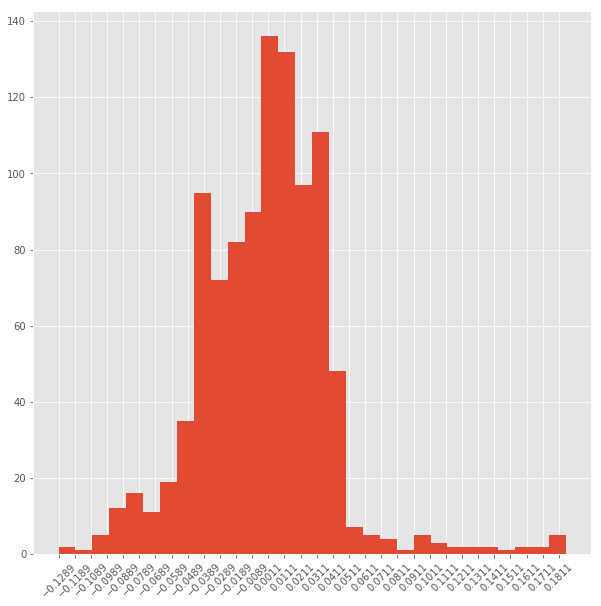

In [123]:
plt.hist(df.dif_current, bins = 30)
plt.xticks(np.arange(min(df.dif_current), max(df.dif_current), 0.01))
plt.xticks(rotation=45)
plt.show()

In [103]:
def log_return(coin=None, date_init = '2017-01-01', date_end = '2018-12-31'):    
    long_df = get_positions(coin, 'closed', date_end)
    mkt_trend_df = get_mkt_trend(coin, date_end, 1)
#     mkt_trend_df = mkt_trend_df[['date', 'screen', 'dif_current', 'delta_dif']] 
    
    merged = pd.merge(long_df, mkt_trend_df, how='inner', left_on=['date_ask'], right_on=['date'])
    fee_taker = 0.0025
    fee_maker = 0.0015
    initial_value = 100
    final_value = initial_value*(1+merged['log_return'])
    fees = [fee_maker*initial_value, fee_taker*final_value]
    result = -initial_value + final_value - fees[0] - fees[1]
    merged['real_return'] = result
    merged['real_log_return'] = np.log((final_value - fees[0] - fees[1])/initial_value)
    merged = merged.drop(['id_position',
                          'date_settlement',
                          'settlement', 
                          'status', 
                          'screen',
                         'vote'], axis = 1)
    return merged
    
print('ALL')
df = log_return()
df['coin'] = df['coin_x']
del df['coin_x']
del df['coin_y']
df['month'] = pd.to_datetime(df['date_ask']).dt.month
df['year'] = pd.to_datetime(df['date_ask']).dt.year

ALL


In [11]:
df.groupby(['year','month']).sum()[['real_return']]

,,real_return
year,month,
2017,12,15.904551
2018,1,-6.014384


In [12]:
df.groupby(['year','month']).max()[['real_return', 'real_log_return']]

,,real_return,real_log_return
year,month,,
2017,12,15.904551,0.147597
2018,1,-6.014384,-0.062028


In [13]:
df.groupby(['year','month']).min()[['real_return', 'real_log_return']]

,,real_return,real_log_return
year,month,,
2017,12,15.904551,0.147597
2018,1,-6.014384,-0.062028


In [14]:
df.groupby(['year','month']).mean()[['real_return', 'real_log_return']]

,,real_return,real_log_return
year,month,,
2017,12,15.904551,0.147597
2018,1,-6.014384,-0.062028


In [15]:
df.groupby(['year','month']).count()[['strategy']]

,,strategy
year,month,
2017,12,1
2018,1,1


All trades in the period below

101.23


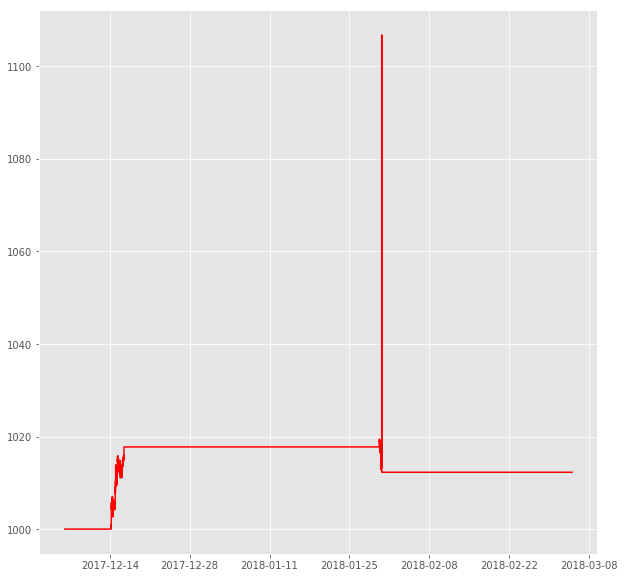

In [16]:
def plot_balance(coin, date):
    df = get_balances(date=date)
    tick = get_tickers(coin = None, screen = 0)
    merged = pd.merge(df, tick, how='left', left_on=['coin', 'date'], right_on=['coin', 'date'])
    merged = merged.fillna(1)
    merged['value'] = merged['size_position'] * merged['price']
    df = merged.groupby(['date'])['value'].sum().reset_index()
    print(round((df.iloc[::-1].iloc[0].value/df.iloc[0].value),4)*100)
    fig, ax = plt.subplots()
    ax.plot(df.date.values, df.value, color = 'red')
    plt.show()
    
plot_balance('USD', '2018-03-05 01:00:00')
